In [213]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sma 
import networkx as nx

from sklearn.preprocessing import StandardScaler
from seaborn import palettes
from itertools import combinations
from joblib import Parallel, delayed

from sklearn.svm import SVC

import sys
sys.path.append('/home/guest/Документы/medstats/Python_scripts')
from importlib import reload
import Parenclitic as prct

import warnings
warnings.filterwarnings("ignore")

In [218]:
X = pd.DataFrame(
    {
        'A': np.random.rand(1, 10).ravel(),
        'B': np.random.rand(1, 10).ravel(),
        'G': np.random.rand(1, 10).ravel()
        }
    )

Y_1 = np.random.randint(2, size=10)
Y_1

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0])

In [350]:
class DataFrameLoader(object):

    def __init__(
            self
        )-> None:
        pass     

    def fit(self, data: pd.core.frame.DataFrame):
        self.data = data
        self.nodes_lst = data.columns
        self.edges_lst = [i for i in list(combinations(self.nodes_lst, r = 2))]


class Prct(object):

    def __init__(self):
        pass


    def fit(self, data):

        dfl = DataFrameLoader()
        self.data = data
        dfl.fit(self.data)
        
        self.nodes_lst = dfl.nodes_lst
        self.edges_lst = dfl.edges_lst

        model_lst = []

        for i in self.edges_lst: 

            _X = sma.add_constant(self.data[i[1]])
            _y = self.data[i[0]]
            model_ols = sma.OLS(_y, _X).fit()
            model_lst = model_lst + [model_ols]
        self._model_lst = model_lst

        _epsilons = np.array([])

        for i, model in zip(self.edges_lst, self._model_lst): 
            _epsilons = np.append(_epsilons, 
                np.array(model.predict(
                                sma.add_constant(self.data[i[1]])) - self.data[i[0]]), axis =0
            )
        self.epsilons = _epsilons.reshape(int(len(_epsilons)/len(self._model_lst)), len(self._model_lst))      


    def transform(self, newdata, newindex=None):      

        sc = StandardScaler()

        new_dfl = DataFrameLoader()
        self.newdata = newdata

        new_dfl.fit(self.newdata)
        
        self.new_nodes_lst = new_dfl.nodes_lst
        self.new_edges_lst = new_dfl.edges_lst

        assert self.new_nodes_lst.all() == self.nodes_lst.all(), f"Train data and new data have different features-nodes"
        assert self.new_edges_lst == self.edges_lst, f"Train data and new data have different features-edges"

        del self.new_nodes_lst
        del self.new_edges_lst

        _new_epsilons = np.array([])
        
        for i, model in zip(self.edges_lst, self._model_lst): 
            _new_epsilons = np.append(_new_epsilons, 
                np.array(model.predict(
                                sma.add_constant(self.newdata[i[1]])) - self.newdata[i[0]]), axis =0
            )
        self.new_epsilons = _new_epsilons.reshape(int(len(_new_epsilons)/len(self._model_lst)), len(self._model_lst))

        sc.fit(self.epsilons)
        self.new_epsilons = np.abs(sc.transform(self.new_epsilons))

        if newindex:
            self.index = newindex
        else:
            self.index = np.array(range(self.new_epsilons.shape[0]))
        

    def ntwrk_construct(self, type = 'thres'):

        self.graphs = dict()

        if type == 'weighted':

            for index in [x for x in range(len(self.index))]:              
                G = nx.Graph()
                G.add_nodes_from(self.nodes_lst)
                for edge, position in [[self.edges_lst[i],i] for i in range(len(self.edges_lst))]:
                    print(edge, position, self.new_epsilons[index, position])
                    G.add_edge(edge[0], edge[1], weight = self.new_epsilons[index, position])

                self.graphs[index] = G

        elif type == 'thres':

            for index in [x for x in range(len(self.index))]:              
                G = nx.Graph()
                G.add_nodes_from(self.nodes_lst)
                for edge, position in [[self.edges_lst[i],i] for i in range(len(self.edges_lst))]:
                    if float(self.new_epsilons[index, position]) > 2:
                        G.add_edge(edge[0], edge[1])

                self.graphs[index] = G

        elif type == 'weighted_thres':

            for index in [x for x in range(len(self.index))]:              
                G = nx.Graph()
                G.add_nodes_from(self.nodes_lst)
                for edge, position in [[self.edges_lst[i],i] for i in range(len(self.edges_lst))]:
                    if float(self.new_epsilons[index, position]) > 2:
                        G.add_edge(edge[0], edge[1], weight = float(self.new_epsilons[index, position]))

                self.graphs[index] = G

        else:
            raise KeyboardError('Type must be `weighted`, `thres` or `weighted_thres`')

# +---------------------------------------------------------------------------------------------------------------------

class Snltc(object):

    def __init__(self):
        pass


    def fit(self, data, labels, clf=None):



        dfl = DataFrameLoader()
        self.data = data
        dfl.fit(self.data)
        
        self.nodes_lst = dfl.nodes_lst
        self.edges_lst = dfl.edges_lst
        self.labels = labels

        model_lst = []

        for i in self.edges_lst: 
            if clf:
                pass
            else:
                clf = SVC(probability = True, random_state=0)

            model_lst = model_lst + [clf.fit(self.data[[i[0], i[1]]], self.labels)]
        self._model_lst = model_lst


    def transform(self, newdata, newindex=None):      

        new_dfl = DataFrameLoader()
        self.newdata = newdata

        new_dfl.fit(self.newdata)
        
        self.new_nodes_lst = new_dfl.nodes_lst
        self.new_edges_lst = new_dfl.edges_lst

        assert self.new_nodes_lst.all() == self.nodes_lst.all(), f"Train data and new data have different features-nodes"
        assert self.new_edges_lst == self.edges_lst, f"Train data and new data have different features-edges"

        del self.new_nodes_lst
        del self.new_edges_lst

        # _new_epsilons = np.zeros_like(self._model_lst)
        _new_epsilons = np.array([])
        
        for i, model in zip(self.edges_lst, self._model_lst): 
            # _new_epsilons = np.append(_new_epsilons, 
            #     np.array(model.predict_proba(self.newdata[[i[0], i[1]]])[:,1]),axis=0)
            _new_epsilons = np.hstack([_new_epsilons, 
                np.array(model.predict_proba(self.newdata[[i[0], i[1]]])[:,1])])
            # print(model.predict_proba(self.newdata[[i[0], i[1]]])[:,1])
        
        self.new_epsilons = _new_epsilons.reshape(len(self._model_lst), int(len(_new_epsilons)/len(self._model_lst))).T

        if newindex:
            self.index = newindex
        else:
            self.index = np.array(range(self.new_epsilons.shape[0]))


    def ntwrk_construct(self, type = 'thres'):

        self.graphs = dict()

        if type == 'weighted':

            for index in [x for x in range(len(self.index))]:              
                G = nx.Graph()
                G.add_nodes_from(self.nodes_lst)
                for edge, position in [[self.edges_lst[i],i] for i in range(len(self.edges_lst))]:
                    G.add_edge(edge[0], edge[1], weight = self.new_epsilons[index, position])

                self.graphs[index] = G

        elif type == 'thres':

            for index in [x for x in range(len(self.index))]:              
                G = nx.Graph()
                G.add_nodes_from(self.nodes_lst)
                for edge, position in [[self.edges_lst[i],i] for i in range(len(self.edges_lst))]:
                    if float(self.new_epsilons[index, position]) > 2:
                        G.add_edge(edge[0], edge[1])

                self.graphs[index] = G

        elif type == 'weighted_thres':

            for index in [x for x in range(len(self.index))]:              
                G = nx.Graph()
                G.add_nodes_from(self.nodes_lst)
                for edge, position in [[self.edges_lst[i],i] for i in range(len(self.edges_lst))]:
                    if float(self.new_epsilons[index, position]) > 2:
                        G.add_edge(edge[0], edge[1], weight = float(self.new_epsilons[index, position]))

                self.graphs[index] = G

        else:
            raise KeyboardError('Type must be `weighted`, `thres` or `weighted_thres`')


('A', 'B') 0 0.44837331206067144
('A', 'G') 1 0.2999712948573955
('B', 'G') 2 0.34415662529374874
('A', 'B') 0 0.4761821380833312
('A', 'G') 1 0.32744047725513054
('B', 'G') 2 0.39170416669029035
('A', 'B') 0 0.6270670222861804
('A', 'G') 1 0.5
('B', 'G') 2 0.3098203392276097
('A', 'B') 0 0.4181215775748521
('A', 'G') 1 0.4944512220626728
('B', 'G') 2 0.6310383775276457
('A', 'B') 0 0.31224413920058025
('A', 'G') 1 0.3313067102408537
('B', 'G') 2 0.28746718122628173
('A', 'B') 0 0.38881282281302465
('A', 'G') 1 0.4903617841616092
('B', 'G') 2 0.6764563908196138
('A', 'B') 0 0.6020839346489898
('A', 'G') 1 0.5432446192388367
('B', 'G') 2 0.3610908892666687
('A', 'B') 0 0.3973318695514474
('A', 'G') 1 0.3300381204015363
('B', 'G') 2 0.3733725603967122
('A', 'B') 0 0.7275247587627638
('A', 'G') 1 0.7332271355114274
('B', 'G') 2 0.37146808928390396
('A', 'B') 0 0.28172268028523106
('A', 'G') 1 0.3554635671133408
('B', 'G') 2 0.6334487000828001
[1 0 1 0 1 0 0 1 1 0]


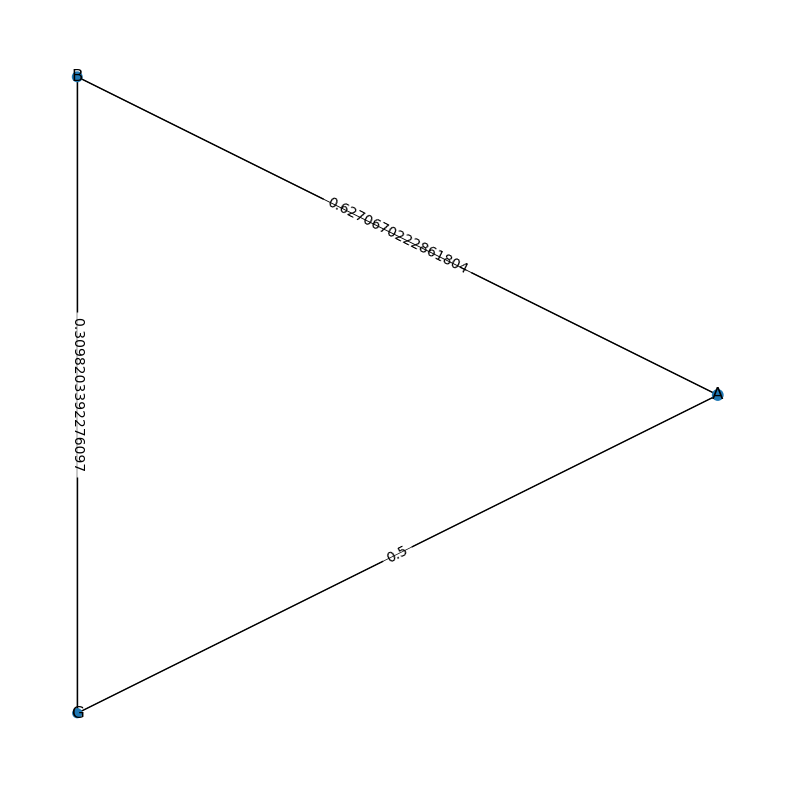

In [363]:
synolitic = Snltc()

synolitic.fit(X, Y_1)

# synolitic.transform(pd.DataFrame(X.loc[0,:]).T)
# synolitic.transform(pd.DataFrame(X.loc[0:1,:]))
synolitic.transform(X)

synolitic.ntwrk_construct(type='weighted')
# synolitic.new_epsilons.T
print(Y_1)
graph_plotter(synolitic.graphs[2])

In [353]:
def graph_plotter(
    G, 
    add_edge_labels = True, 
    add_nodes_size = True,
    figsize=(10,10), 
    title='',
    save = False
    ):

    """
    Creates circular graph plot with node size 
    (through weighted degree) and edge width depending
    on edge weights

    Parameters
    ----------
    :G: networkx.classes.graph.Graph

    :add_edge_labels: bool
        edge labels will be shown

    :add_nodes_size: bool
        node size will adjusted according to weighted
        node degree * 50
    
    :figsize: set
        set of plot size for matplotlib plt.subplots() function

    :title: str
        plot title

    Returns
    ----------
    Plot of a graph

    """
    
    pos = nx.circular_layout(G)   

    edge_labels = dict([((n1, n2), d['weight']) for 
        n1, n2, d in G.edges(data=True)])

    degree_dict = dict(G.degree(weight='weight'))

    plt.figure(figsize=figsize)
    plt.title(title)

    nx.draw(G, pos, with_labels = True, node_size=[v * 50 for v in degree_dict.values()])

    if add_edge_labels:
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, label_pos=0.5)

    if add_nodes_size:
        for edge in G.edges(data='weight'):
            nx.draw_networkx_edges(G, pos, edgelist=[edge], width=edge[2])

        
    if save:
        plt.savefig(title, bbox_inches="tight", transparent=False)
    
    else:
        plt.show()